# Estimating effective lockdown date for COVID-19 pandemic
<a href="https://colab.research.google.com/github/surajx/AIFS/blob/master/labs/Machine%20Learning/Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use [Google Mobility dataset](https://www.google.com/covid19/mobility/) and [Prophet](https://facebook.github.io/prophet/) to find changepoints that indicate a significant reduction in mobility during the 2020 COVID-19 pandemic.

In [1]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

import matplotlib.pyplot as plt
import logging
import pandas as pd

In [2]:
logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [30]:
df = pd.read_csv('../data/google_global_mobility_data_14May.csv')
df

,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
335458,ZW,Zimbabwe,NaN,NaN,2020-05-05,-40.0,-31.0,-30.0,-61.0,-39.0,30.0
335459,ZW,Zimbabwe,NaN,NaN,2020-05-06,-37.0,-26.0,-31.0,-57.0,-38.0,31.0
335460,ZW,Zimbabwe,NaN,NaN,2020-05-07,-35.0,-25.0,-34.0,-57.0,-37.0,31.0
335461,ZW,Zimbabwe,NaN,NaN,2020-05-08,-38.0,-25.0,-35.0,-59.0,-33.0,31.0


In [4]:
target_countries = ['AU', 'BR', 'ES', 'GB', 'IN', 'IT', 'KR', 'SE', 'US']
mobility_type_map = {
    'work': 'workplaces_percent_change_from_baseline',
    'home': 'residential_percent_change_from_baseline',
    'transit_hub': 'transit_stations_percent_change_from_baseline',
    'parks':'parks_percent_change_from_baseline',
    'grocery': 'grocery_and_pharmacy_percent_change_from_baseline',
    'recreation': 'retail_and_recreation_percent_change_from_baseline'
}
mobility_plot_name_map = {
    'work': 'Workplace',
    'home': 'Residential',
    'transit_hub': 'Transit Stations',
    'parks':'Parks',
    'grocery': 'Groicery and Pharmacy',
    'recreation': 'Retail and Recreation'
}

In [17]:
def get_country_df_for_mobility(mobility='work'):
    country_df_map = {}
    for country in target_countries:
        country_df = (df
                        .loc[(df.country_region_code==country)]
                        .loc[(pd.isnull(df.sub_region_1))]
                        .loc[(pd.isnull(df.sub_region_2))]
                        .loc[:, ['date', mobility_type_map[mobility], 'country_region']]
        )
        country_name = country_df.iloc[0]['country_region']
        country_df = country_df.drop(['country_region'], axis=1)
        country_df.date = pd.to_datetime(country_df.date)
        country_df = (country_df
                        .rename(columns={'date': 'ds', mobility_type_map[mobility]: 'y'})  # Naming convention needed for prophet
                        .reset_index(drop=True)
        )
        country_df_map[country] = {
            'df': country_df,
            'name': country_name,
            'type': mobility_plot_name_map[mobility]
        }
    return country_df_map

country_df_map = {}
for mobility in mobility_type_map.keys():
    country_df_map[mobility] = get_country_df_for_mobility(mobility=mobility)

In [20]:
def forecast_for_country(country_df_map, changepoint_prior_scale=0.05, forecast_period=10):
    prophet = Prophet(changepoint_prior_scale=changepoint_prior_scale, changepoint_range=0.8)
    prophet.fit(country_df_map['df'])
    future = prophet.make_future_dataframe(periods=forecast_period, freq='D', include_history=True)
    forecast = prophet.predict(future)

    return prophet, forecast


def plot_workplace_mobility_for_country(country_df_map, changepoint_prior_scale=0.8, forecast_period=10):
    prophet, forecast = forecast_for_country(country_df_map, changepoint_prior_scale=changepoint_prior_scale, forecast_period=forecast_period)
    fig = prophet.plot(forecast, xlabel='Date', ylabel='{} Mobility'.format(country_df_map['type']))
    plt.title('{} Mobility Graph for {}'.format(country_df_map['type'], country_df_map['name']))
    add_changepoints_to_plot(fig.gca(), prophet, forecast, cp_color='blue')

    return prophet

In [21]:
def get_lockdown_dates_from_prophet(prophet, mobility='work'):    
    chng_pts_df = pd.DataFrame(prophet.changepoints.reset_index(drop=True))
    chng_pts_df['delta'] = prophet.params['delta'][0]
    chng_pts_df_filterd = (chng_pts_df
                    .loc[(chng_pts_df.delta>0) if mobility=='home' else (chng_pts_df.delta<0)]
                    .loc[(chng_pts_df.delta.idxmax()) if mobility=='home' else (chng_pts_df.delta.idxmin())]
    )
    return chng_pts_df_filterd['ds']

def plot_mobility_change_points(mobility='work'):
    lockdown_dates = {}
    for country in target_countries:
        if country=='SE' or country=='KR':
            cp_prior = 4  # Sweden and South Korea need a different prior for a better fit.
        else:
            cp_prior = 0.8
        prophet = plot_workplace_mobility_for_country(country_df_map[mobility][country], changepoint_prior_scale=cp_prior, forecast_period=0)
        lockdown_dates[country] = get_lockdown_dates_from_prophet(prophet, mobility=mobility)
        plt.axvline(lockdown_dates[country], color='red', linestyle='solid', linewidth='3.', label="Effective Lockdown date")
        plt.legend()
        plt.savefig('../plots/{}_Mobility/svg/{}_{}.svg'.format(mobility_plot_name_map[mobility], country_df_map[mobility][country]['name'], mobility_plot_name_map[mobility]), bbox_inches = 'tight', format='svg')
        plt.savefig('../plots/{}_Mobility/png/{}_{}.png'.format(mobility_plot_name_map[mobility], country_df_map[mobility][country]['name'], mobility_plot_name_map[mobility]), bbox_inches = 'tight', format='png', dpi=300)
    return lockdown_dates

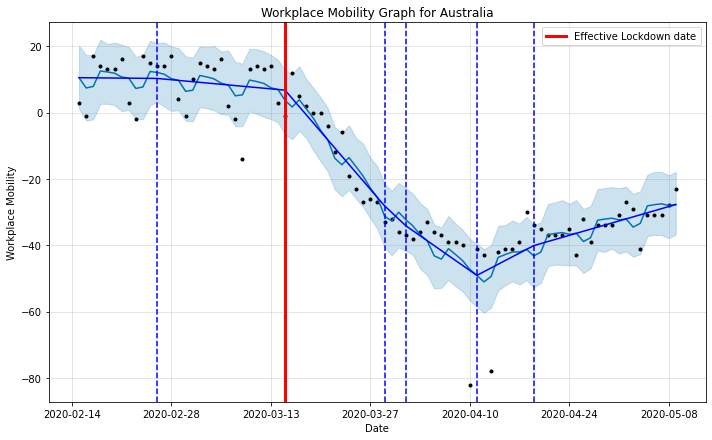

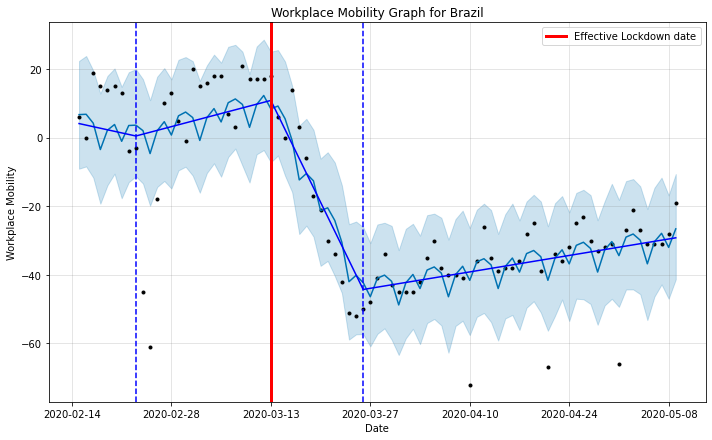

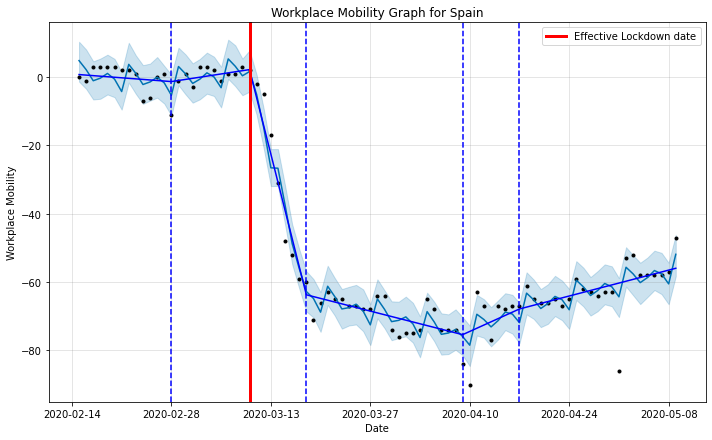

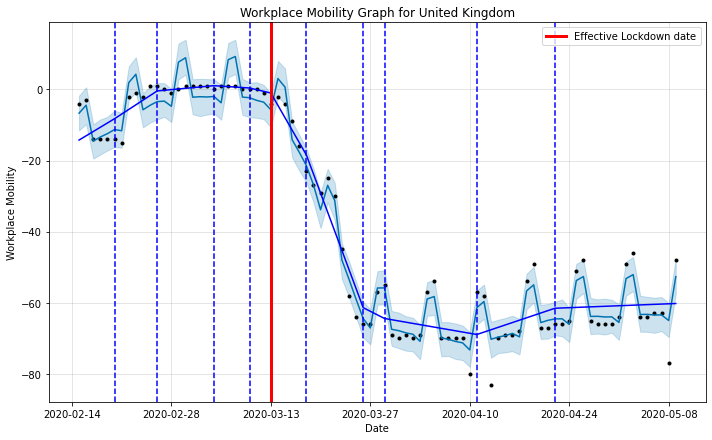

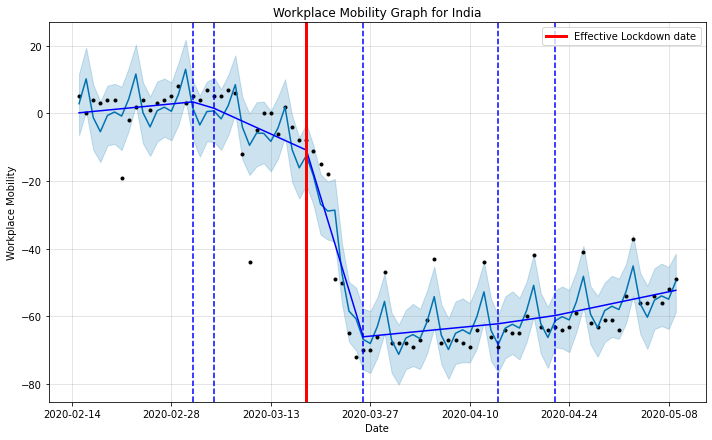

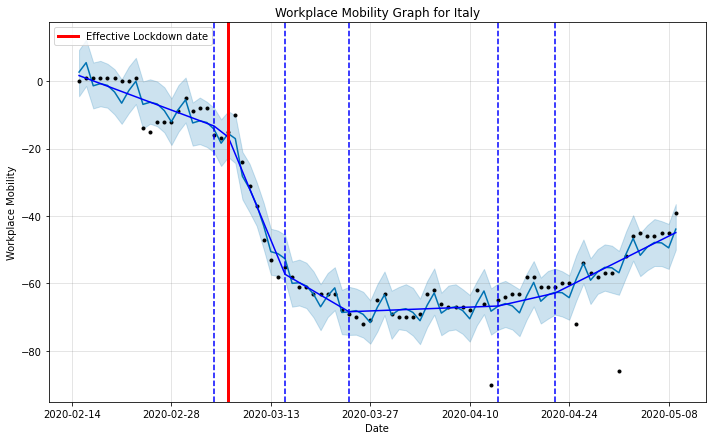

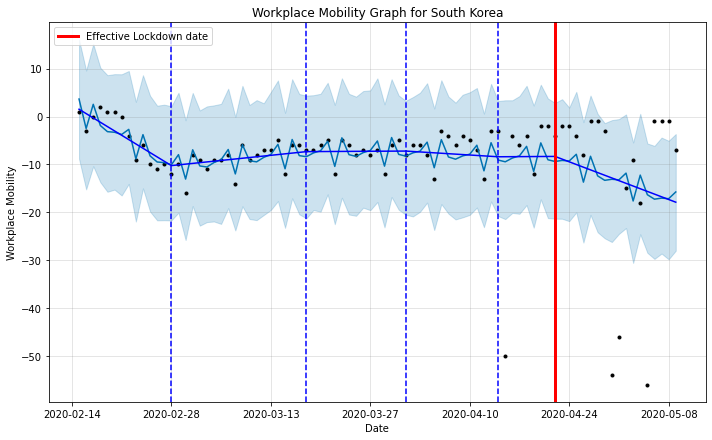

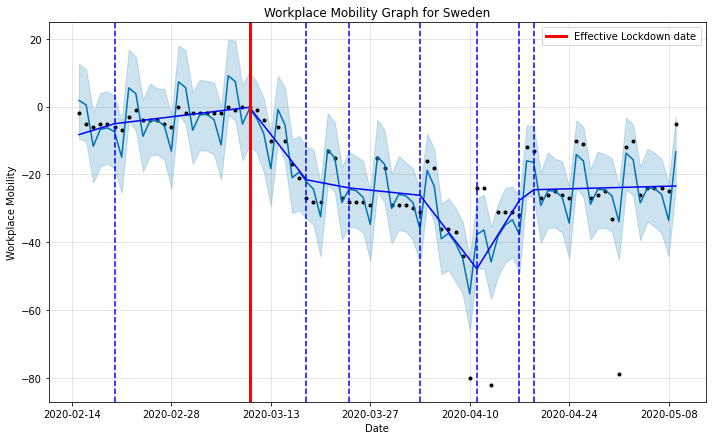

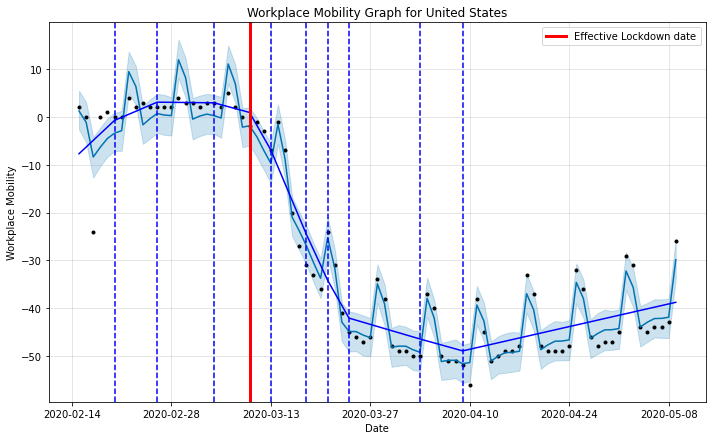

In [22]:
work_lockdown_dates = plot_mobility_change_points(mobility='work')

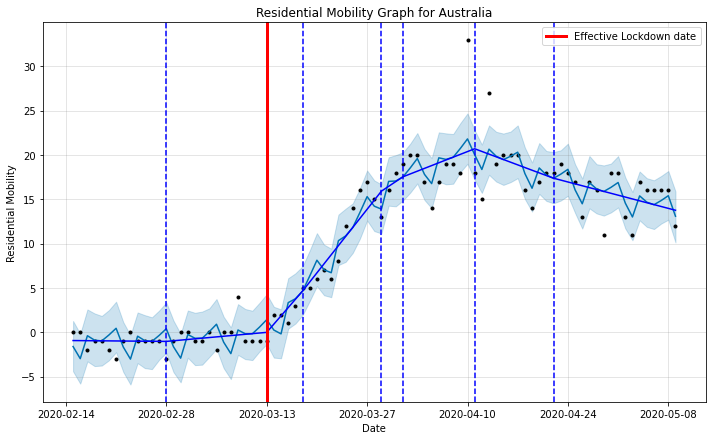

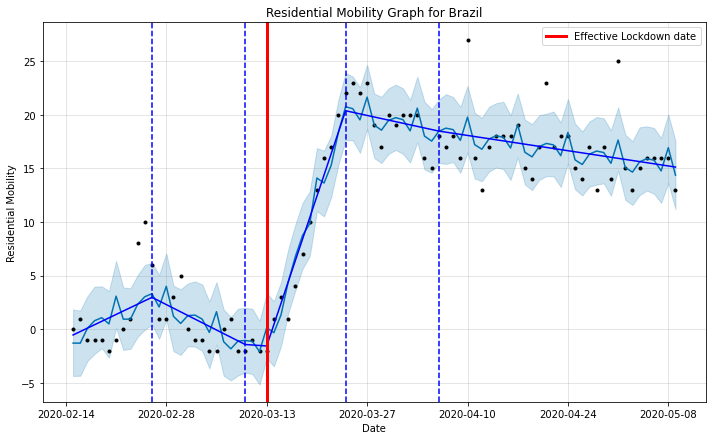

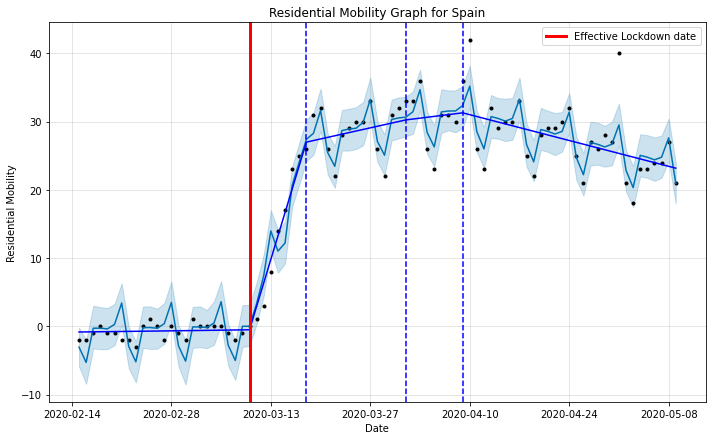

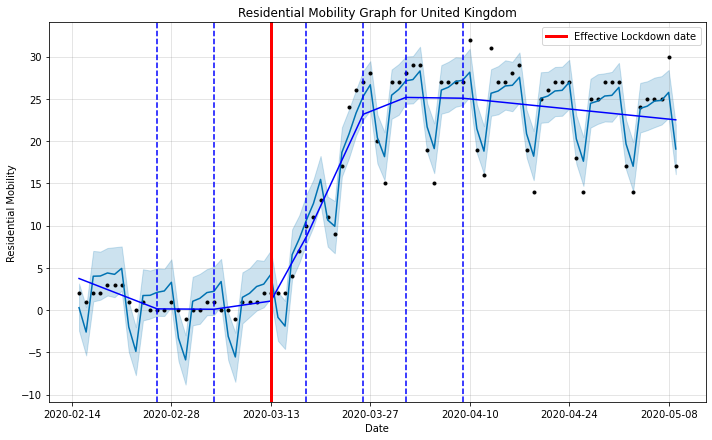

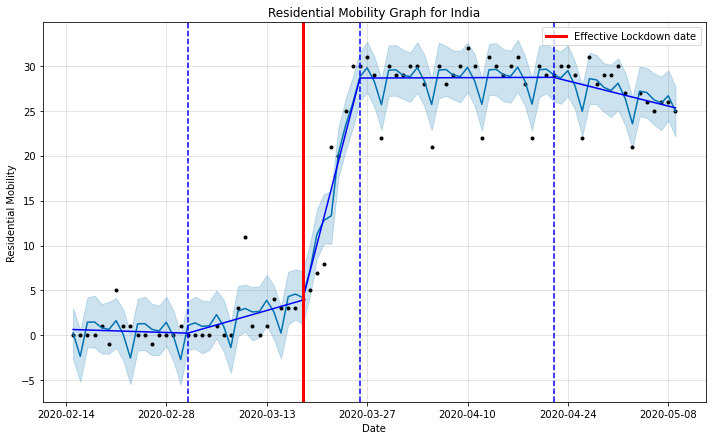

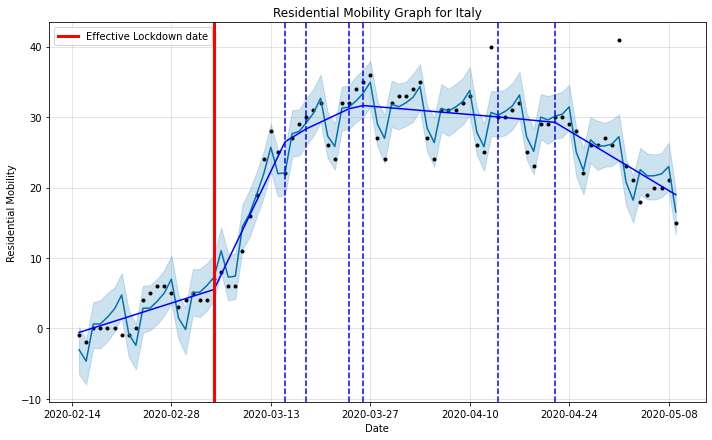

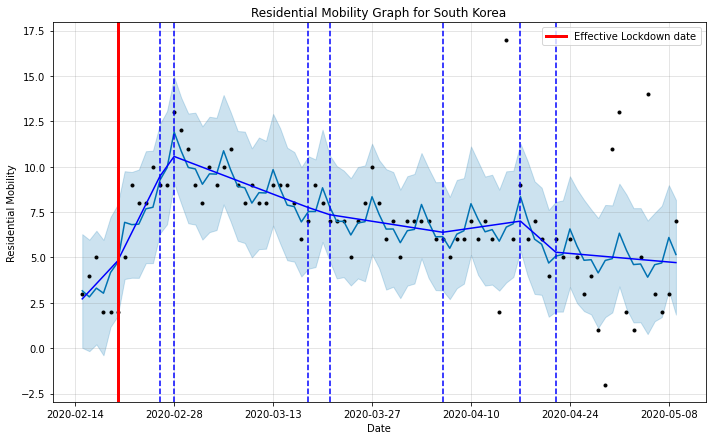

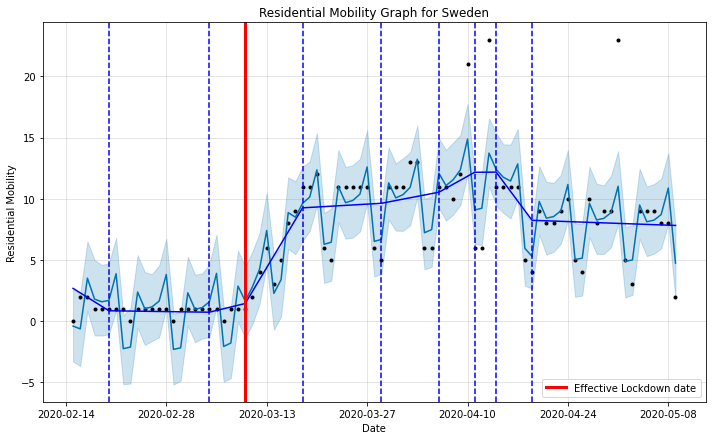

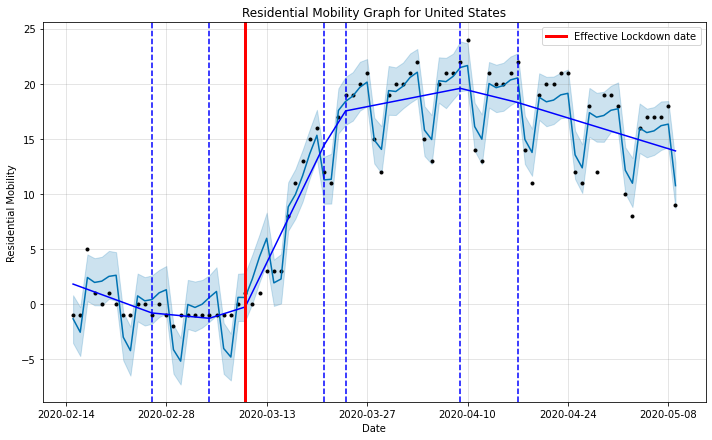

In [23]:
home_lockdown_dates = plot_mobility_change_points(mobility='home')

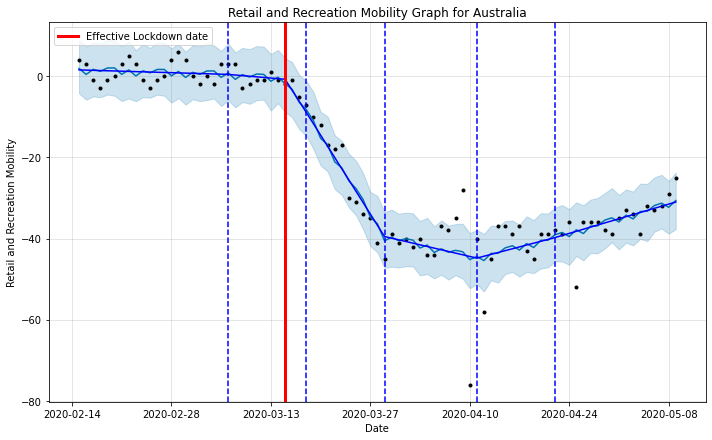

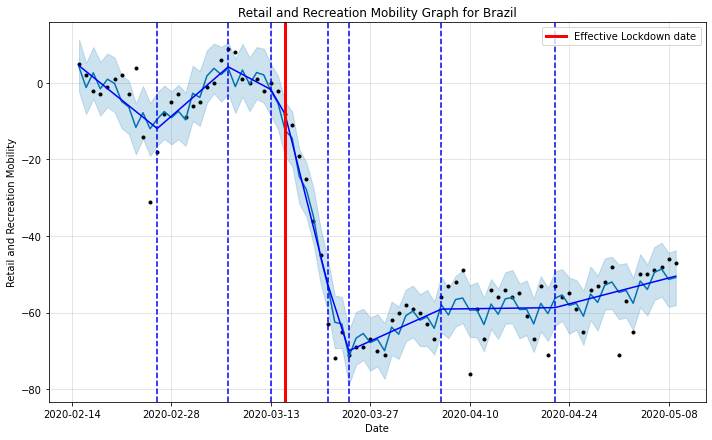

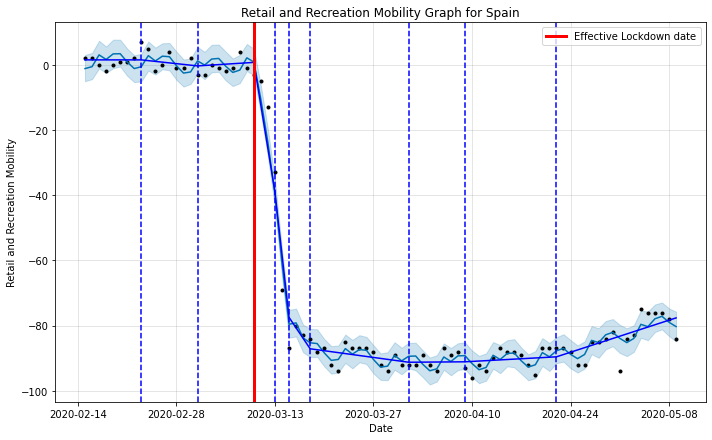

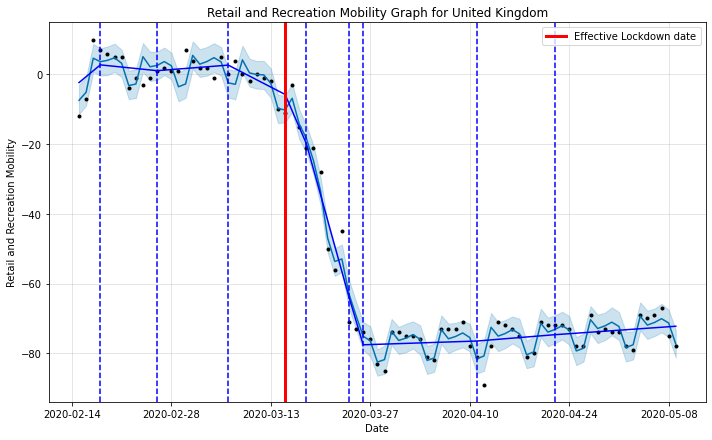

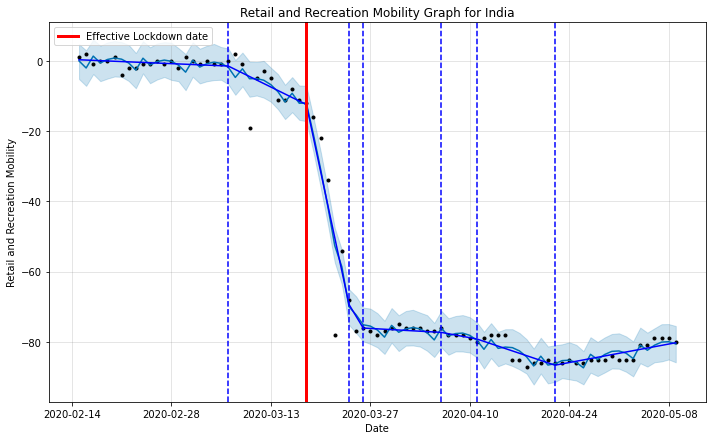

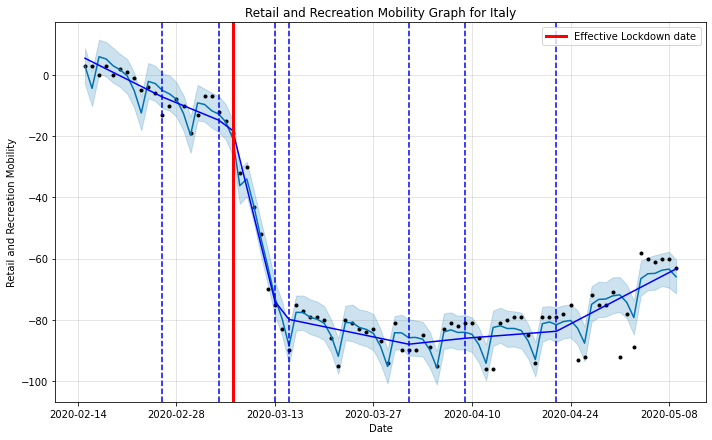

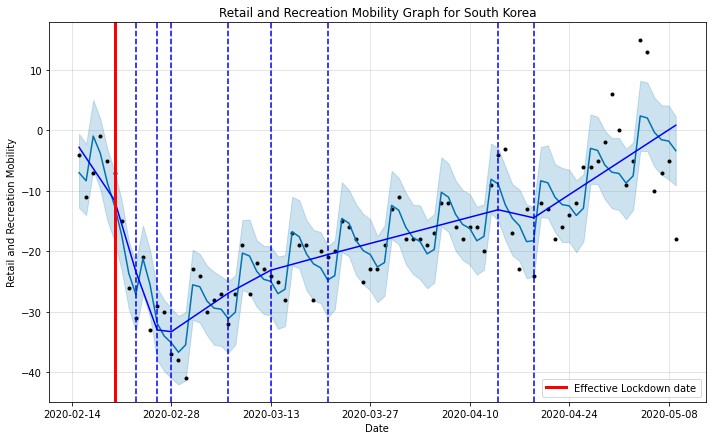

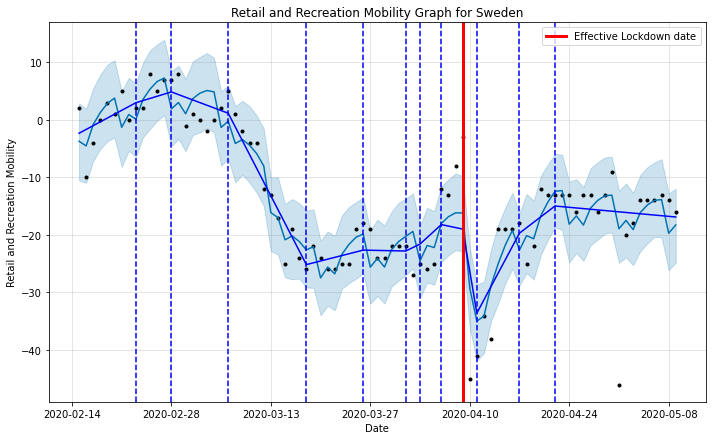

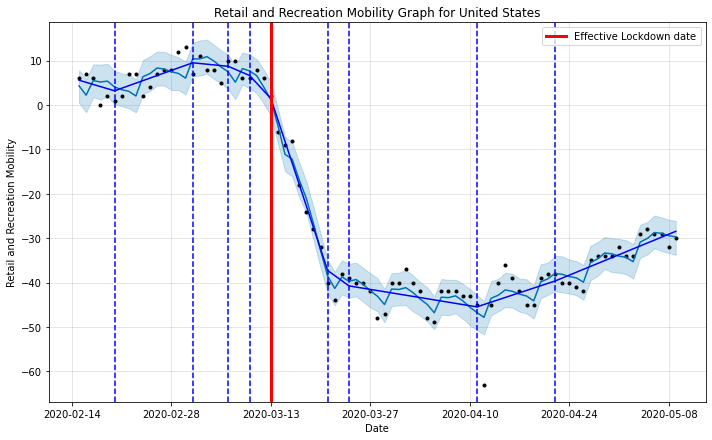

In [24]:
recreation_lockdown_dates = plot_mobility_change_points(mobility='recreation')

In [34]:
"Workpalce:",work_lockdown_dates,"Residential:",home_lockdown_dates,"Retail and Recreation:",recreation_lockdown_dates

('Workpalce:',
 {'AU': Timestamp('2020-03-15 00:00:00'),
  'BR': Timestamp('2020-03-13 00:00:00'),
  'ES': Timestamp('2020-03-10 00:00:00'),
  'GB': Timestamp('2020-03-13 00:00:00'),
  'IN': Timestamp('2020-03-18 00:00:00'),
  'IT': Timestamp('2020-03-07 00:00:00'),
  'KR': Timestamp('2020-04-22 00:00:00'),
  'SE': Timestamp('2020-03-10 00:00:00'),
  'US': Timestamp('2020-03-10 00:00:00')},
 'Residential:',
 {'AU': Timestamp('2020-03-13 00:00:00'),
  'BR': Timestamp('2020-03-13 00:00:00'),
  'ES': Timestamp('2020-03-10 00:00:00'),
  'GB': Timestamp('2020-03-13 00:00:00'),
  'IN': Timestamp('2020-03-18 00:00:00'),
  'IT': Timestamp('2020-03-05 00:00:00'),
  'KR': Timestamp('2020-02-20 00:00:00'),
  'SE': Timestamp('2020-03-10 00:00:00'),
  'US': Timestamp('2020-03-10 00:00:00')},
 'Retail and Recreation:',
 {'AU': Timestamp('2020-03-15 00:00:00'),
  'BR': Timestamp('2020-03-15 00:00:00'),
  'ES': Timestamp('2020-03-10 00:00:00'),
  'GB': Timestamp('2020-03-15 00:00:00'),
  'IN': Timesta

## Lockdown Dates inferred from Residential Mobility

* Australia: 2020-03-13
* Brazil: 2020-03-13
* Spain: 2020-03-10
* United Kingdom: 2020-03-13
* India: 2020-03-18
* Italy: 2020-03-05
* South Korea: 2020-02-20
* Sweden: 2020-03-10
* United States: 2020-03-10

## Lockdown Dates inferred from Workplace Mobility

* Australia: 2020-03-15
* Brazil: 2020-03-13
* Spain: 2020-03-10
* United Kingdom: 2020-03-13
* India: 2020-03-18
* Italy: 2020-03-07
* South Korea: 2020-04-22
* Sweden: 2020-03-10
* United States: 2020-03-10

## Lockdown Dates inferred from Retail and Recreation Mobility

* Australia: 2020-03-15
* Brazil: 2020-03-15
* Spain: 2020-03-10
* United Kingdom: 2020-03-15
* India: 2020-03-18
* Italy: 2020-03-07
* South Korea: 2020-02-20
* Sweden: 2020-04-09
* United States: 2020-03-13